In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

In [2]:
df_train = pd.read_csv('train.csv', index_col=0)
display(df_train.head())

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
original_df = df_train.copy()

## Feature Extraction

### Split Cabin column

In [4]:
# Add empty columns
df_train['Cabin_1'] = pd.Series([None]*len(df_train))
df_train['Cabin_2'] = pd.Series([None]*len(df_train))
df_train['Cabin_3'] = pd.Series([None]*len(df_train))

In [5]:
# Fill up empty columns
def cabin_split(row):
    if type(row['Cabin']) == float and np.isnan(row['Cabin']):
        return row
    split = row['Cabin'].split('/')
    #print(split)
    row['Cabin_1'] = split[0]
    row['Cabin_2'] = split[1]
    row['Cabin_3'] = split[2]
    return row
    
df_train = df_train.apply(cabin_split, axis=1)

### Get sex by name

In [6]:
# Load dataset with (name -> sex) relation (https://archive.ics.uci.edu/dataset/591/gender+by+name)
df_names = pd.read_csv('name_gender_dataset.csv', index_col='Name')
df_names = df_names.sort_values('Probability', ascending=False)
df_names = df_names[~df_names.index.duplicated(keep='first')]  # Remove all duplicates in index except the first one 
display(df_names.loc['John'])

# To get most probable sex for specific name
df_names.loc['John']['Gender']

Gender                M
Count           5260831
Probability    0.014398
Name: John, dtype: object

'M'

In [7]:
# Create empty column
df_train['Sex'] = pd.Series([None] * len(df_train))

In [8]:
# Get sex by name

# For performance
names_set = set(df_names.index)
names_to_sex_dict = df_names['Gender'].to_dict()

def sex_by_name(row):
    if pd.isna(row['Name']):
        return row
    name = row['Name'].split(' ')[0]
    if name in names_set:
        row['Sex'] = names_to_sex_dict[name]
    return row

df_train = df_train.apply(sex_by_name, axis=1)

In [9]:
df_train['Sex'].value_counts()

Sex
F    1930
M    1075
Name: count, dtype: int64

## Type Correction

In [10]:
# check types
df_train.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Cabin_1          object
Cabin_2          object
Cabin_3          object
Sex              object
dtype: object

In [11]:
df_train.nunique()

HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
Cabin_1            8
Cabin_2         1817
Cabin_3            2
Sex                2
dtype: int64

In [12]:
# unique values
df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Cabin_1', 'Cabin_3', 'Sex']].apply(lambda x: x.unique())

HomePlanet                         [Europa, Earth, Mars, nan]
CryoSleep                                  [False, True, nan]
Destination    [TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan]
VIP                                        [False, True, nan]
Transported                                     [False, True]
Cabin_1                         [B, F, A, G, nan, E, D, C, T]
Cabin_3                                           [P, S, nan]
Sex                                               [F, nan, M]
dtype: object

In [13]:
# transfrom CryoSleep, VIP and Transported to float64
display(df_train[['CryoSleep', 'VIP', 'Transported', 'Cabin_2']])
df_train['CryoSleep'] = df_train['CryoSleep'].astype('float64')
df_train['VIP'] = df_train['VIP'].astype('float64')
df_train['Transported'] = df_train['Transported'].astype('float64')
df_train['Cabin_2'] = df_train['Cabin_2'].astype('float64')
display(df_train[['CryoSleep', 'VIP', 'Transported', 'Cabin_2']])

,CryoSleep,VIP,Transported,Cabin_2
PassengerId,,,,
0001_01,False,False,False,0
0002_01,False,False,True,0
0003_01,False,True,False,0
0003_02,False,False,False,0
0004_01,False,False,True,1
...,...,...,...,...
9276_01,False,True,False,98
9278_01,True,False,False,1499
9279_01,False,False,True,1500


,CryoSleep,VIP,Transported,Cabin_2
PassengerId,,,,
0001_01,0.0,0.0,0.0,0.0
0002_01,0.0,0.0,1.0,0.0
0003_01,0.0,1.0,0.0,0.0
0003_02,0.0,0.0,0.0,0.0
0004_01,0.0,0.0,1.0,1.0
...,...,...,...,...
9276_01,0.0,1.0,0.0,98.0
9278_01,1.0,0.0,0.0,1499.0
9279_01,0.0,0.0,1.0,1500.0


## Pick out categorical and numerical columns

In [14]:
# Drop out unnecessary columns
to_drop = ['Name', 'Cabin']
df_train.drop(to_drop, axis=1, inplace=True)

In [15]:
df_train.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Transported        2
Cabin_1            8
Cabin_2         1817
Cabin_3            2
Sex                2
dtype: int64

In [16]:
# categorical columns
cat_columns = df_train.columns[df_train.nunique() < 10]
display(df_train[cat_columns])
display(df_train[cat_columns].nunique())
display(df_train['HomePlanet'].value_counts())
display(df_train['Destination'].value_counts())
display(df_train['Cabin_1'].value_counts())
display(df_train['Cabin_3'].value_counts())
display(df_train['Sex'].value_counts())

,HomePlanet,CryoSleep,Destination,VIP,Transported,Cabin_1,Cabin_3,Sex
PassengerId,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,0.0,0.0,B,P,F
0002_01,Earth,0.0,TRAPPIST-1e,0.0,1.0,F,S,F
0003_01,Europa,0.0,TRAPPIST-1e,1.0,0.0,A,S,NaN
0003_02,Europa,0.0,TRAPPIST-1e,0.0,0.0,A,S,NaN
0004_01,Earth,0.0,TRAPPIST-1e,0.0,1.0,F,S,M
...,...,...,...,...,...,...,...,...
9276_01,Europa,0.0,55 Cancri e,1.0,0.0,A,P,NaN
9278_01,Earth,1.0,PSO J318.5-22,0.0,0.0,G,S,M
9279_01,Earth,0.0,TRAPPIST-1e,0.0,1.0,G,S,NaN


HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
Transported    2
Cabin_1        8
Cabin_3        2
Sex            2
dtype: int64

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

Cabin_1
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

Cabin_3
S    4288
P    4206
Name: count, dtype: int64

Sex
F    1930
M    1075
Name: count, dtype: int64

In [17]:
num_columns = df_train.columns[df_train.nunique() > 10]
df_train[num_columns]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_2
PassengerId,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0.0
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,1.0
...,...,...,...,...,...,...,...
9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,98.0
9278_01,18.0,0.0,0.0,0.0,0.0,0.0,1499.0
9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,1500.0


## Manual correlation analysis

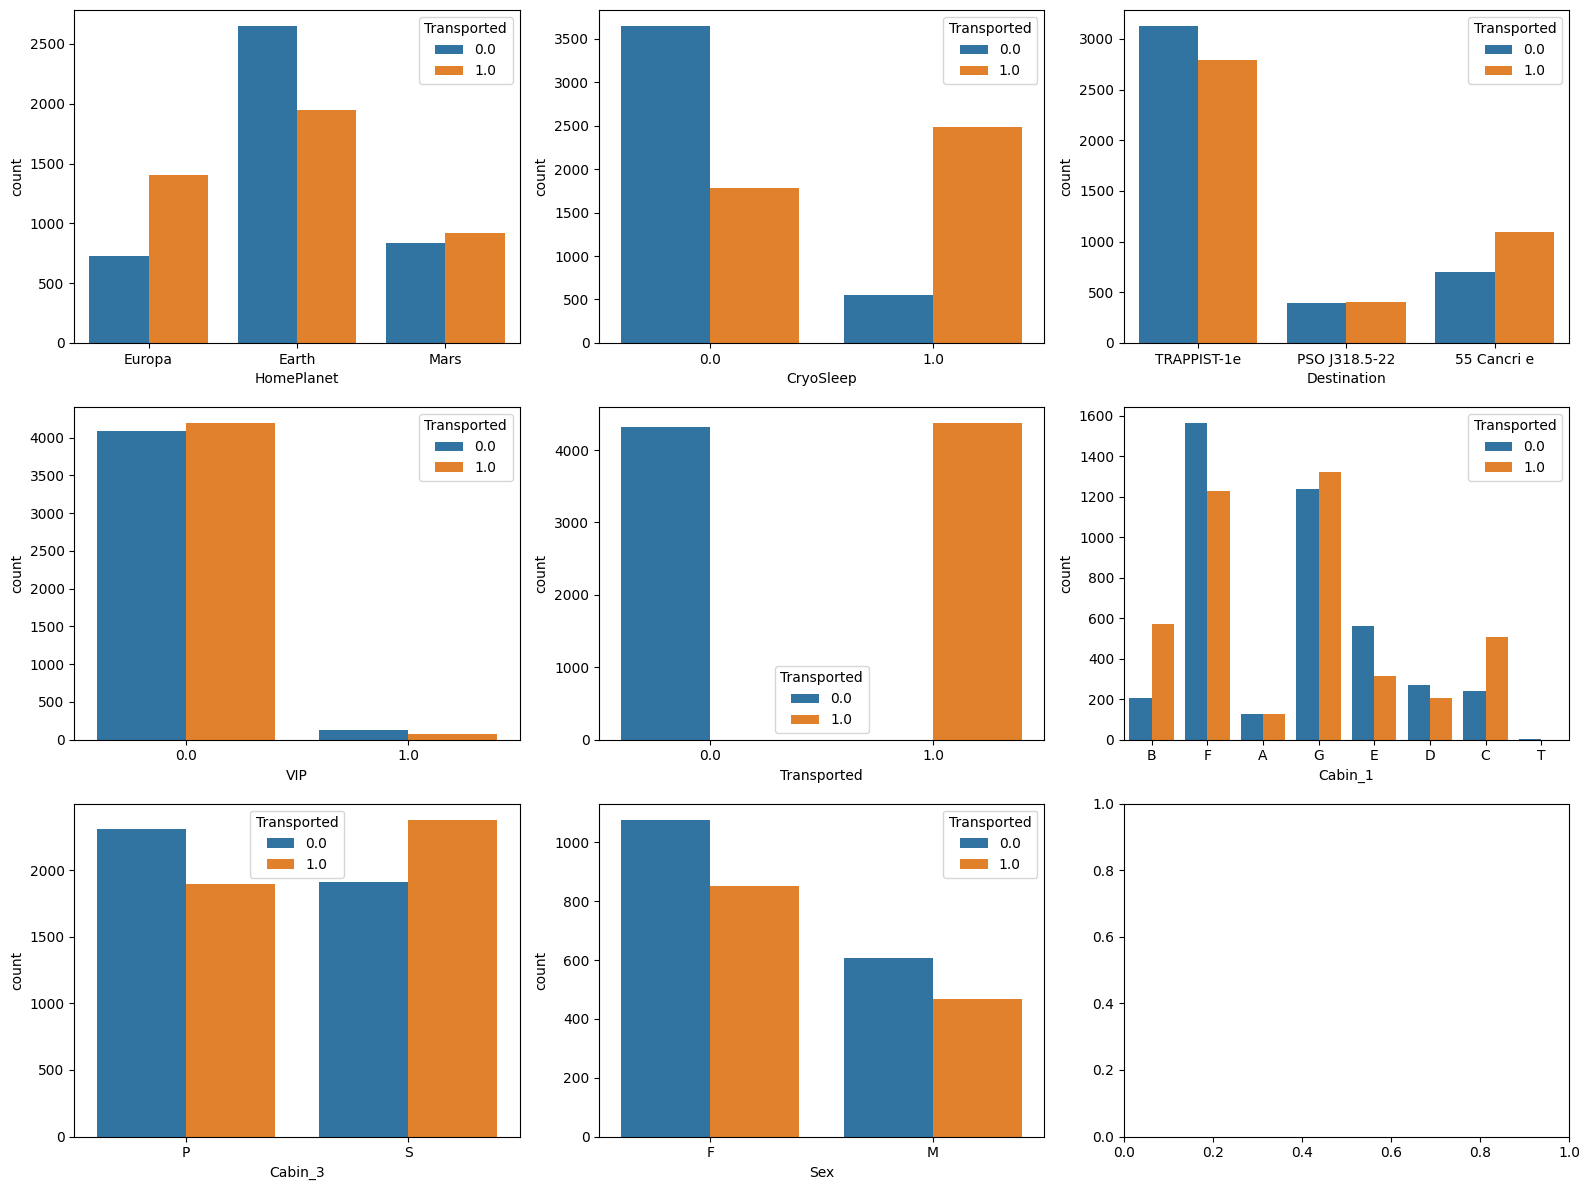

In [18]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(12)
fig.set_figwidth(16)
axs = axs.ravel()
for i, c in enumerate(cat_columns):
    sns.countplot(ax=axs[i], data=df_train, x=c, hue='Transported')
plt.tight_layout()
plt.show()

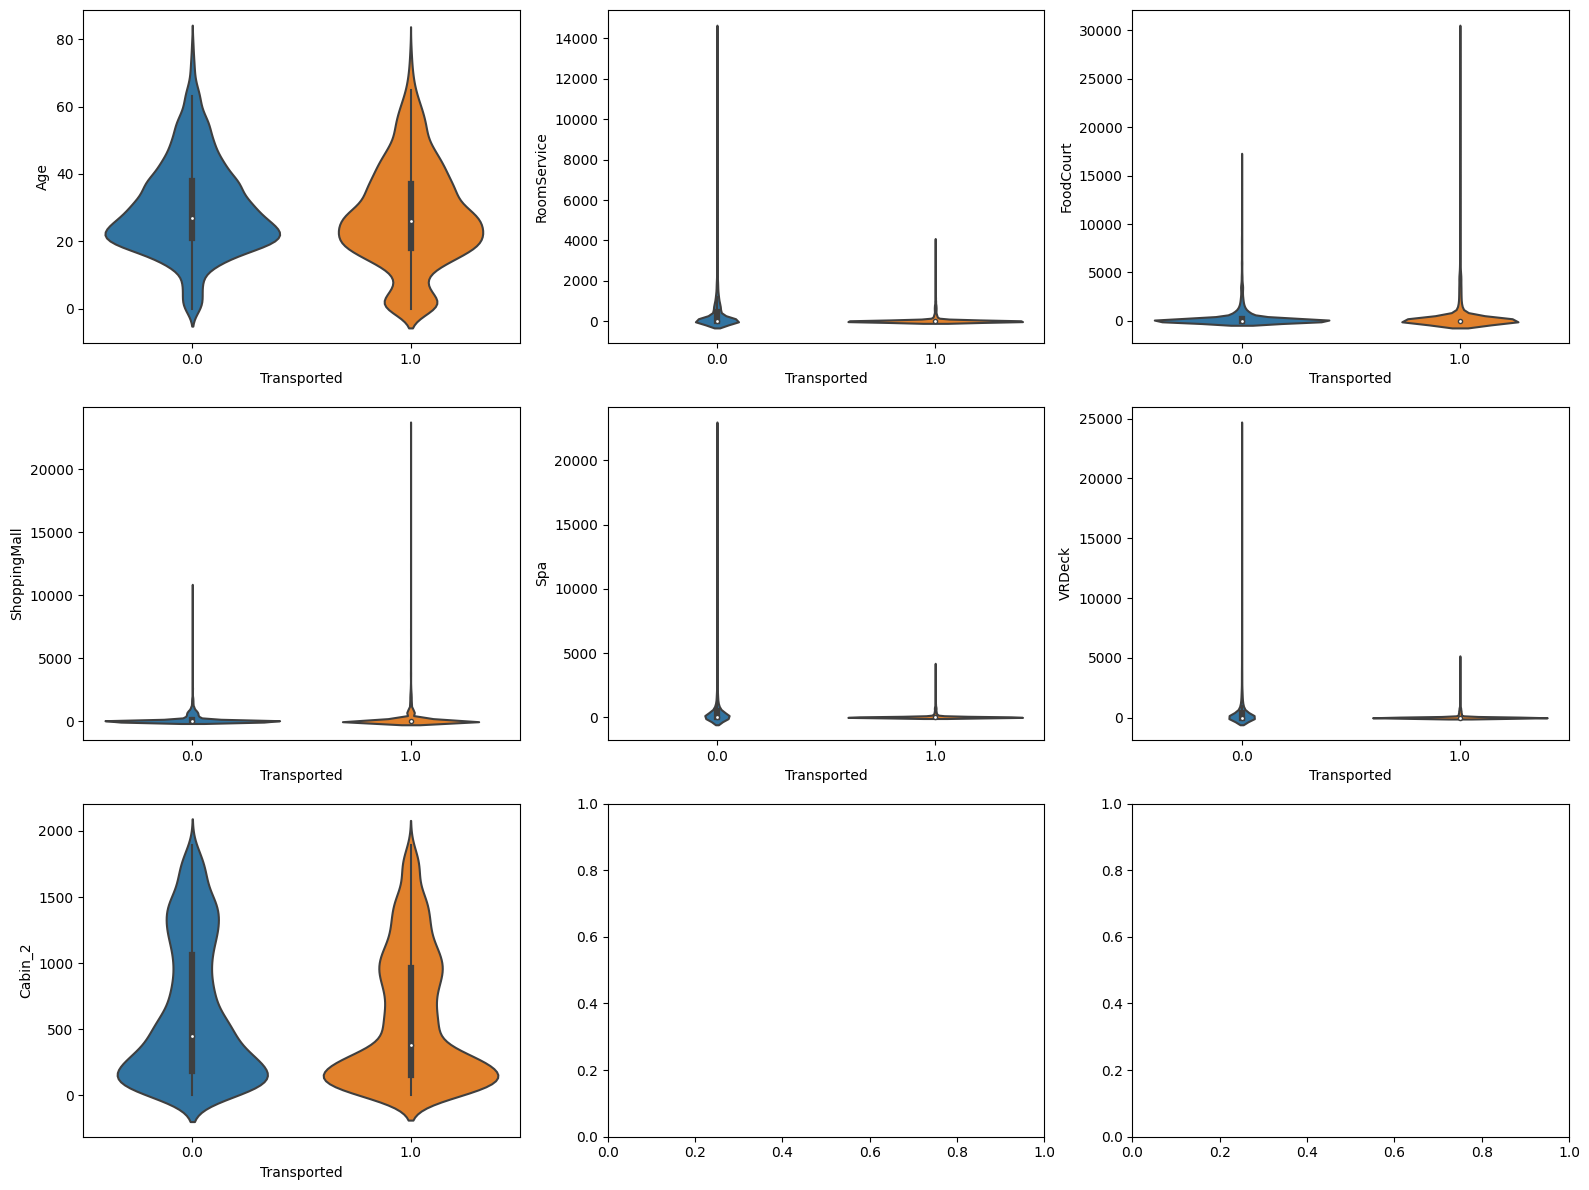

In [19]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(12)
fig.set_figwidth(16)
axs = axs.ravel()
for i, c in enumerate(num_columns):
    sns.violinplot(ax=axs[i], data=df_train, y=c, x='Transported')
plt.tight_layout()
plt.show()

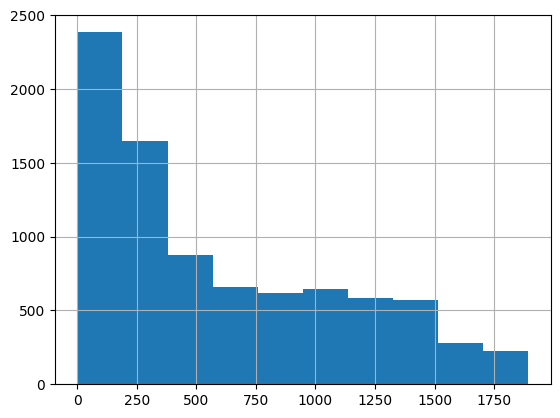

600.3676712973864

427.0

In [20]:
# Check distribution for every column
col = 'Cabin_2'
df_train[col].hist()
plt.show()
display(df_train[col].mean())
display(df_train[col].median())

## Label encoding

In [21]:
df_train['Sex'].unique()

array(['F', nan, 'M'], dtype=object)

In [22]:
df_train['HomePlanet'] = df_train['HomePlanet'].map({'Earth':0, 'Europa':1, 'Mars':2}).astype('float')
df_train['Destination'] = df_train['Destination'].map({'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2}).astype('float')
df_train['Cabin_1'] = df_train['Cabin_1'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7}).astype('float')
df_train['Cabin_3'] = df_train['Cabin_3'].map({'P':0, 'S':1}).astype('float')
df_train['Sex'] = df_train['Sex'].map({'F':0, 'M':1}).astype('float')

In [23]:
df_train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_1,Cabin_2,Cabin_3,Sex
PassengerId,,,,,,,,,,,,,,,
0001_01,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0002_01,0.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,5.0,0.0,1.0,0.0
0003_01,1.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,0.0,1.0,NaN
0003_02,1.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,0.0,1.0,NaN
0004_01,0.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,5.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,1.0,0.0,2.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0.0,0.0,98.0,0.0,NaN
9278_01,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1499.0,1.0,1.0
9279_01,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1.0,6.0,1500.0,1.0,NaN


## Missing values columns

In [36]:
# check for None
df_train.isnull().sum()

HomePlanet       201
CryoSleep        217
Destination      182
Age              179
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Transported        0
Cabin_1          199
Cabin_2          199
Cabin_3          199
Sex             5688
dtype: int64

In [37]:
# create duplicates for missing columns
df_missing = original_df.isnull().drop(['Transported'], axis=1).astype('float')
df_missing.columns = [f'miss_{c}' for c in original_df.columns[:-1]]
df_missing = pd.concat([df_train, df_missing], axis=1)
display(df_missing)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,miss_Cabin,miss_Destination,miss_Age,miss_VIP,miss_RoomService,miss_FoodCourt,miss_ShoppingMall,miss_Spa,miss_VRDeck,miss_Name
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,0.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_01,1.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003_02,1.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0004_01,0.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,1.0,0.0,2.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9278_01,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9279_01,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Handling missing values
df_train['HomePlanet'].fillna(df_train['HomePlanet'].mode()[0], inplace=True)
df_train['CryoSleep'].fillna(method='ffill', inplace=True)
df_train['Destination'].fillna(df_train['Destination'].mode()[0], inplace=True)
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_train['VIP'].fillna(df_train['VIP'].mode()[0], inplace=True)
df_train['RoomService'].fillna(df_train['RoomService'].median(), inplace=True)
df_train['FoodCourt'].fillna(df_train['FoodCourt'].median(), inplace=True)
df_train['ShoppingMall'].fillna(df_train['ShoppingMall'].median(), inplace=True)
df_train['Spa'].fillna(df_train['Spa'].median(), inplace=True)
df_train['VRDeck'].fillna(df_train['VRDeck'].median(), inplace=True)
df_train['Cabin_1'].fillna(df_train['Cabin_1'].mode()[0], inplace=True)
df_train['Cabin_2'].fillna(df_train['Cabin_2'].mean(), inplace=True)
df_train['Cabin_3'].fillna(df_train['Cabin_3'].mode()[0], inplace=True)
df_train['Sex'].fillna(method='ffill', inplace=True)

In [39]:
df_train.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Cabin_1         0
Cabin_2         0
Cabin_3         0
Sex             0
dtype: int64

## BoxCox transformation

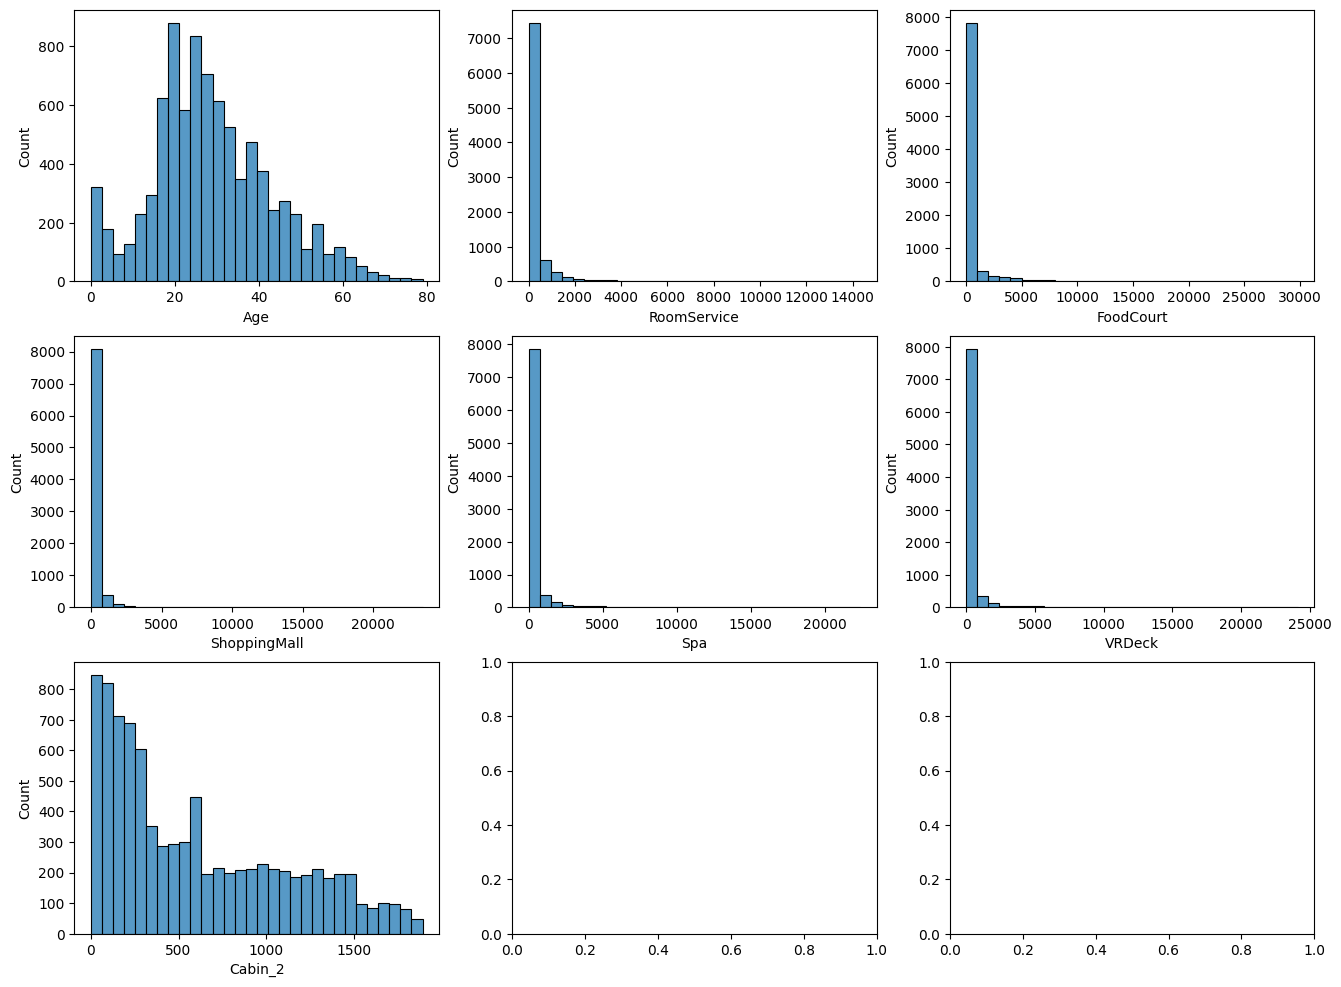

In [40]:
# Explore numeric columns
f,ax = plt.subplots(3,3)
f.set_figheight(12)
f.set_figwidth(16)
ax = ax.flatten()
for i, c in enumerate(num_columns):
    sns.histplot(df_train[c], bins=30, ax=ax[i])
plt.show()

In [45]:
# # Apply BoxCox
# from scipy.stats import boxcox

# for c in num_columns:   
#     df_train[c], _ = boxcox(df_train[c] + 1)

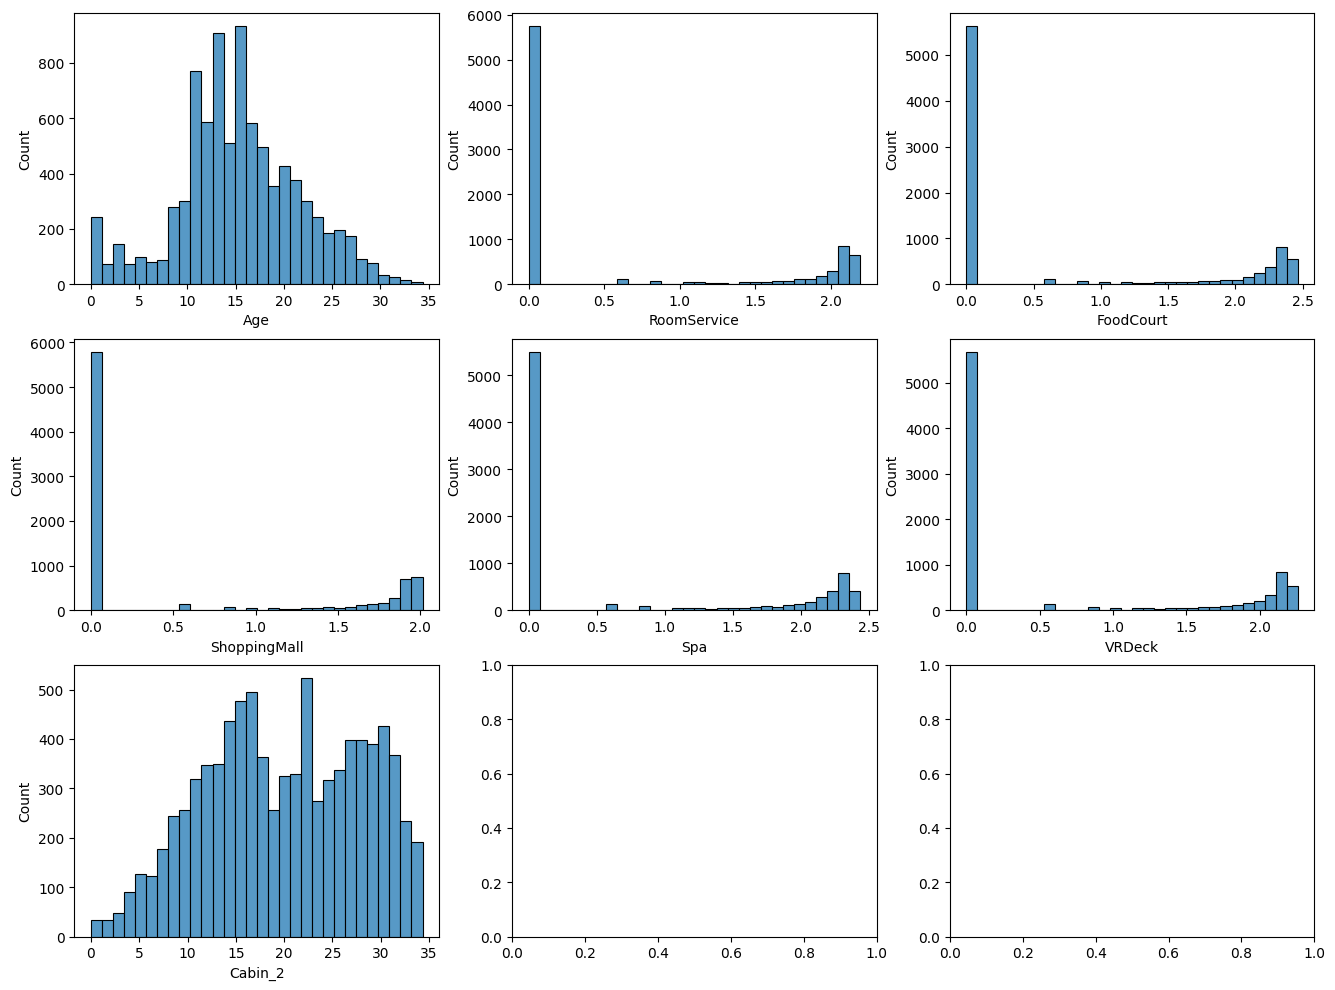

In [46]:
# Explore numeric columns
f,ax = plt.subplots(3,3)
f.set_figheight(12)
f.set_figwidth(16)
ax = ax.flatten()
for i, c in enumerate(num_columns):
    sns.histplot(df_train[c], bins=30, ax=ax[i])
plt.show()

## Correlation check

In [47]:
for c in df_train.columns:
    df_missing[c] = df_train[c]

In [48]:
# classic correlation
pearson_corr = df_missing.corr(method='pearson')
kendall_corr = df_missing.corr(method='kendall')

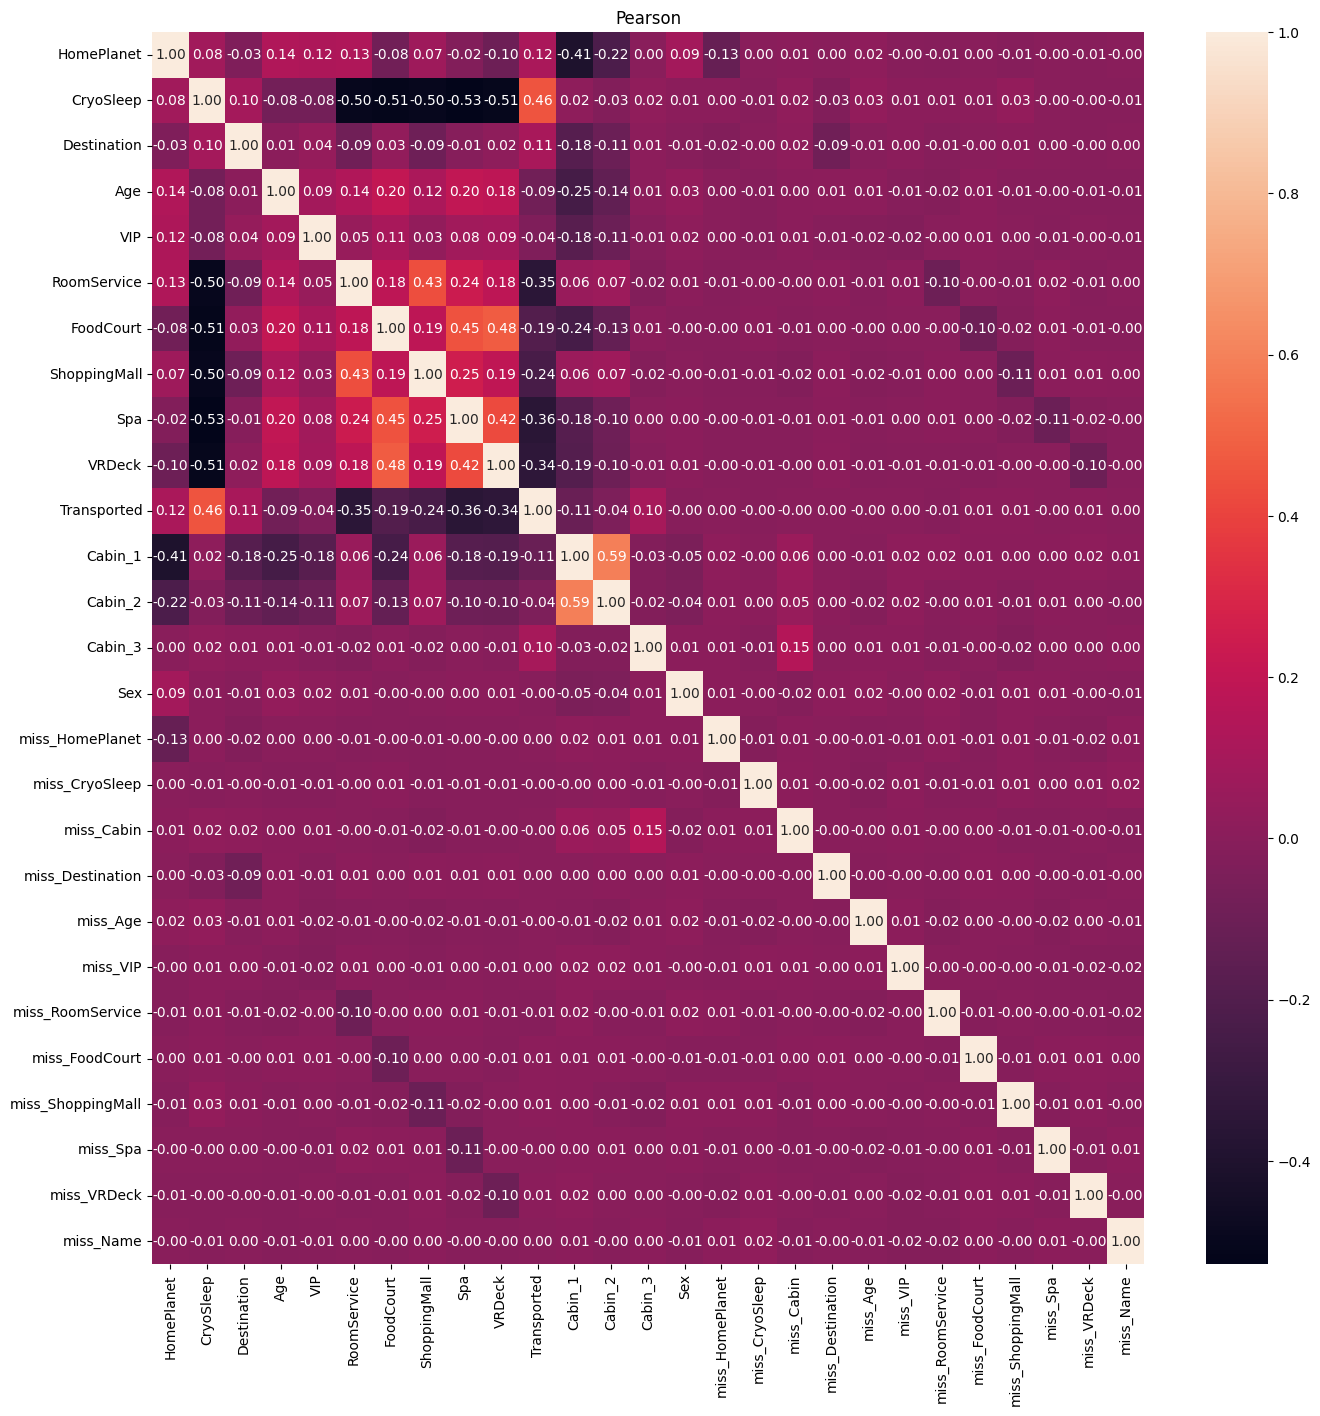

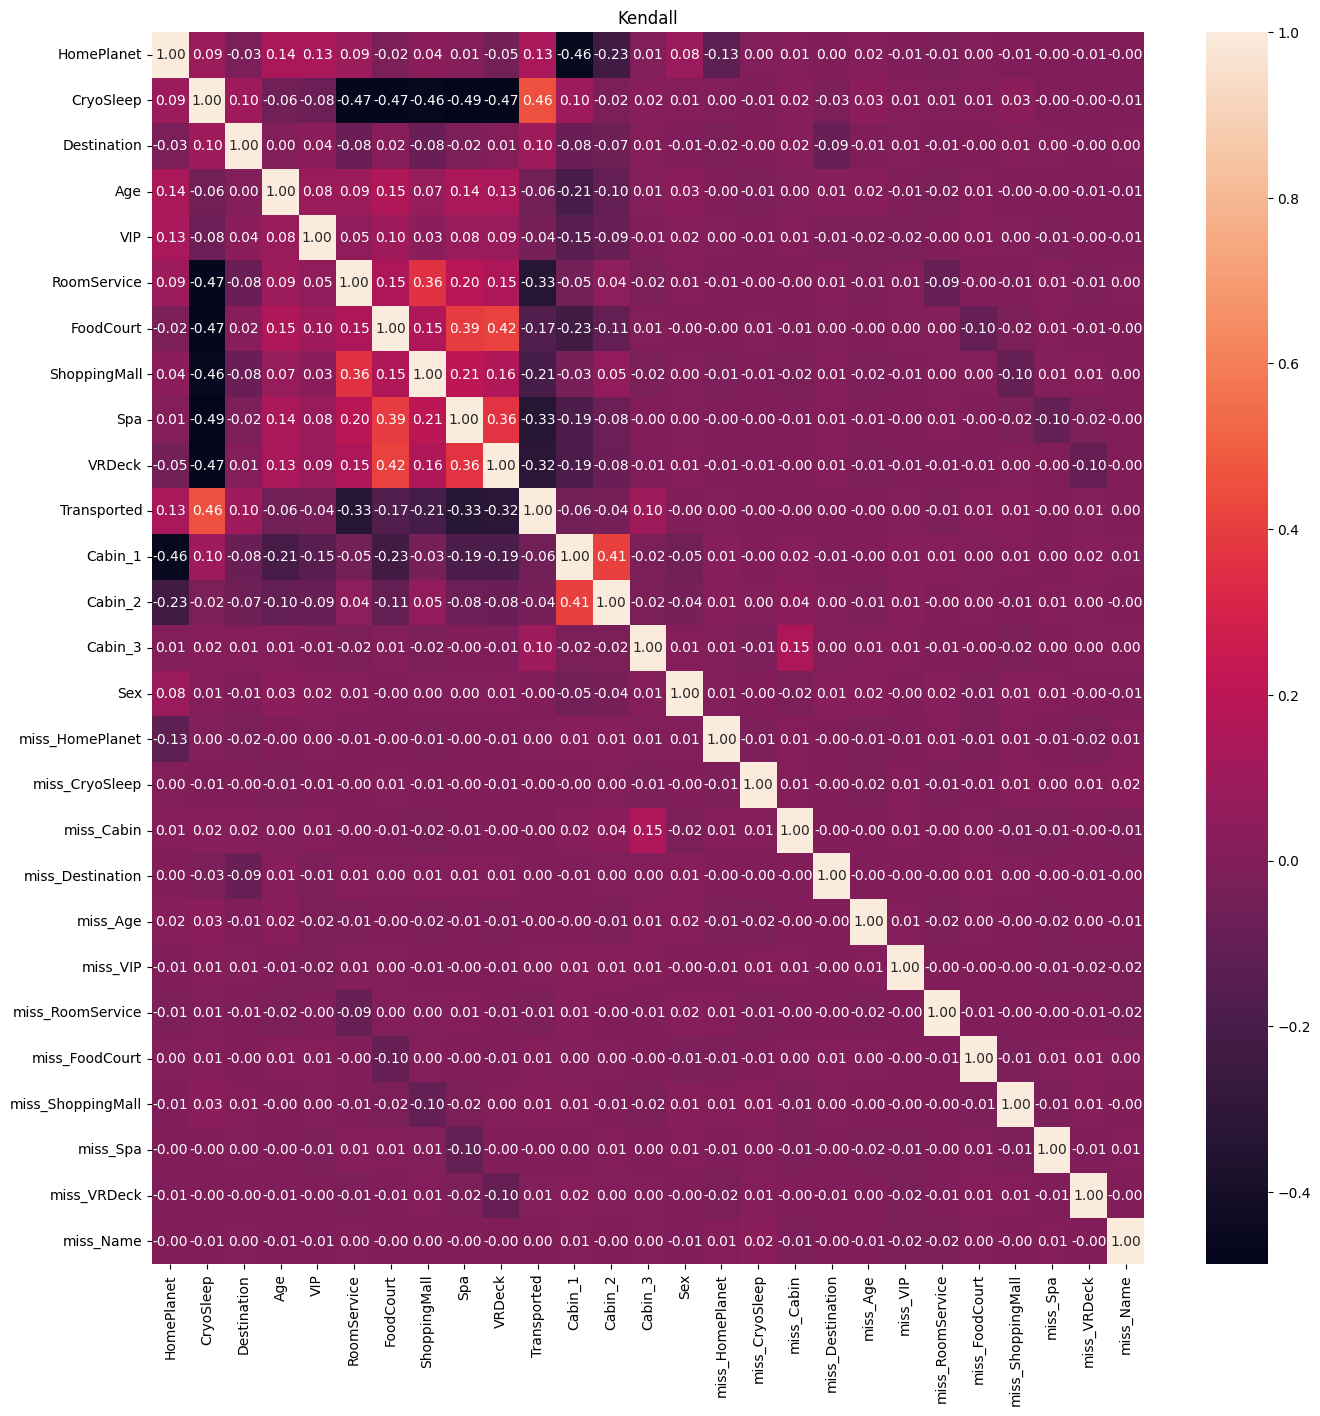

Transported     1.000000
CryoSleep       0.456062
Spa            -0.357400
RoomService    -0.354961
VRDeck         -0.338478
ShoppingMall   -0.236285
FoodCourt      -0.194208
HomePlanet      0.115461
Cabin_1        -0.114941
Destination     0.108152
Cabin_3         0.101397
Name: Transported, dtype: float64
Transported     1.000000
CryoSleep       0.456062
RoomService    -0.334189
Spa            -0.333830
VRDeck         -0.318010
ShoppingMall   -0.208744
FoodCourt      -0.170578
HomePlanet      0.129362
Cabin_3         0.101397
Destination     0.100664
Name: Transported, dtype: float64


In [49]:
plt.figure(figsize=(16,16))
plt.title('Pearson')
sns.heatmap(pearson_corr, annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(16,16))
plt.title('Kendall')
sns.heatmap(kendall_corr, annot=True, fmt='.2f')
plt.show()

print(pearson_corr[pearson_corr['Transported'].abs() > 0.1]['Transported'].sort_values(ascending=False, key=abs))
print(kendall_corr[kendall_corr['Transported'].abs() > 0.1]['Transported'].sort_values(ascending=False, key=abs))

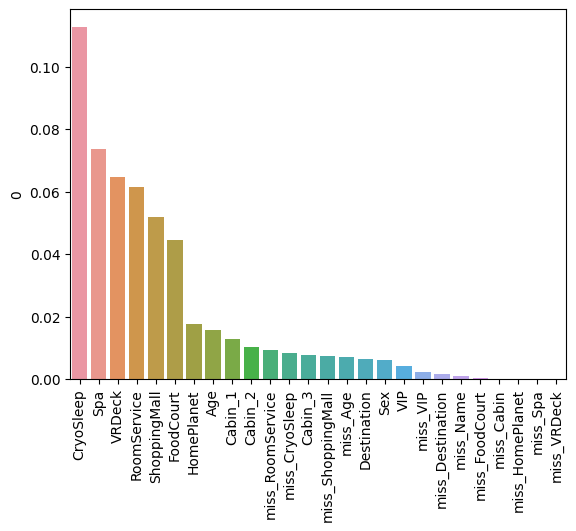

In [50]:
# mutual information
mutual_info = mutual_info_classif(
    X = df_missing.drop(['Transported'], axis=1),
    y = df_missing['Transported'],
#    discrete_features = ['CryoSleep', 'VIP', 'HomePlanet', 'Destination', *[c for c in df_missing.columns if c[:5] == 'miss_']],
)

# reformat mutual info into df
indices = [*df_missing.columns]
indices.remove('Transported')
mi_df = pd.DataFrame(mutual_info, index=indices).sort_values(0, ascending=False)

# show
plt.xticks(rotation=90)
sns.barplot(x=mi_df.index, y=mi_df[0])
plt.show()

ROC-AUC: 0.8550504153127146


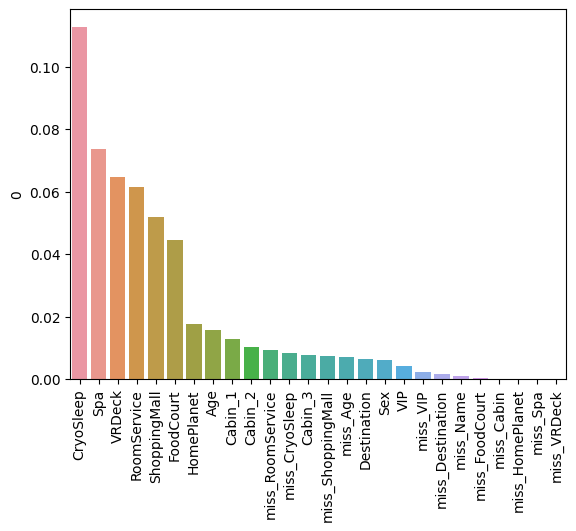

In [51]:
# random forest feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier(n_estimators=1000, max_depth=4)
scores = cross_val_score(model, df_train.drop('Transported', axis=1), df_train['Transported'], cv=5, scoring='roc_auc')
model.fit(df_train.drop('Transported', axis=1), df_train['Transported'])
fe_df = pd.DataFrame(model.feature_importances_, index=df_train.drop('Transported', axis=1).columns)

# show
print('ROC-AUC:', scores.mean())
plt.xticks(rotation=90)
sns.barplot(x=mi_df.index, y=mi_df[0])
plt.show()

> **Note**
>
> - Columns with **high** correlation with target are:
>   - CryoSleep
>   - Spa  
>   - RoomService 
>   - VRDeck  
>   - ShoppingMall
>   - FoodCourt 
> - Columns with **medium** correlation with target are:
>   - HomePlanet  
>   - miss_VRDeck
>   - miss_Cabin
>   - Age
>   - Destination    
>   - Cabin_1
>   - Cabin_2
>   - Cabin_3
> - Most missing values have **no correlation** with target
> - Other columns have **low** correlation

## Select columns

In [52]:
high_corr_columns = ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'ShoppingMall', 'FoodCourt'] 
medium_corr_columns = ['HomePlanet', 'miss_VRDeck', 'miss_Cabin', 'Age', 'Destination', 'Cabin_1', 'Cabin_2', 'Cabin_3']
selected_columns = high_corr_columns + medium_corr_columns
df_train = df_missing[selected_columns + ['Transported']]
df_train

,CryoSleep,Spa,RoomService,VRDeck,ShoppingMall,FoodCourt,HomePlanet,miss_VRDeck,miss_Cabin,Age,Destination,Cabin_1,Cabin_2,Cabin_3,Transported
PassengerId,,,,,,,,,,,,,,,
0001_01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,19.894200,0.0,1.0,0.000000,0.0,0.0
0002_01,0.0,2.283597,1.956234,1.854236,1.621215,1.506156,0.0,0.0,0.0,13.585521,0.0,5.0,0.000000,1.0,1.0
0003_01,0.0,2.407002,1.819078,1.873731,0.000000,2.410341,1.0,0.0,0.0,27.082224,0.0,0.0,0.000000,1.0,0.0
0003_02,0.0,2.383863,0.000000,2.058675,1.918443,2.361995,1.0,0.0,0.0,17.457147,0.0,0.0,0.000000,1.0,0.0
0004_01,0.0,2.285831,2.054959,0.872394,1.857680,2.048681,0.0,0.0,0.0,9.836797,0.0,5.0,0.780104,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0.0,2.352933,0.000000,1.940911,0.000000,2.432073,1.0,0.0,0.0,20.685754,2.0,0.0,10.916129,0.0,0.0
9278_01,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.809039,1.0,6.0,31.533114,1.0,0.0
9279_01,0.0,0.604635,0.000000,0.000000,1.978610,0.000000,0.0,0.0,0.0,14.472422,0.0,6.0,31.540811,1.0,1.0


## Check correlation between features

In [53]:
pearson = df_train.drop('Transported', axis=1).corr(method='pearson')
kendall = df_train.drop('Transported', axis=1).corr(method='kendall')

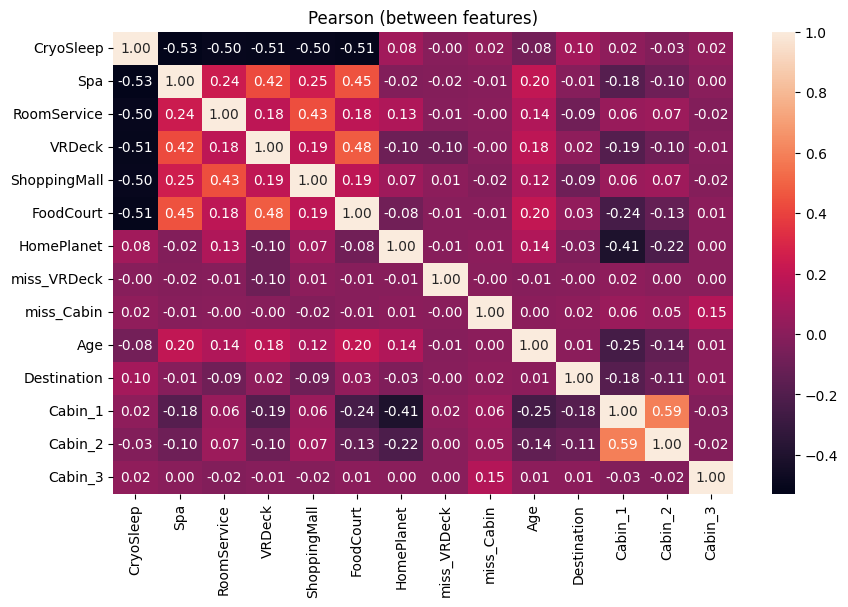

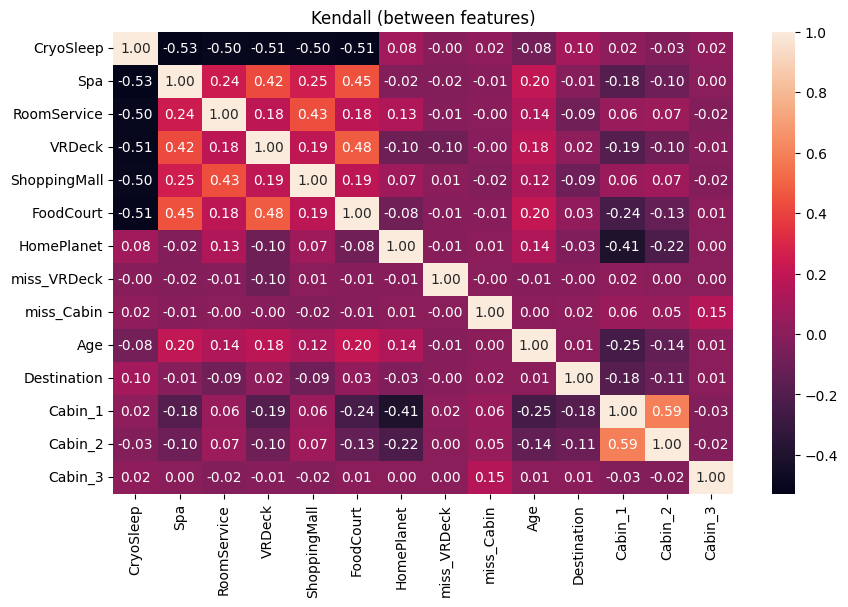

In [54]:
# pearson
plt.figure(figsize=(10,6))
plt.title('Pearson (between features)')
sns.heatmap(pearson, annot=True, fmt='.2f')
plt.show()

# kendall
plt.figure(figsize=(10,6))
plt.title('Kendall (between features)')
sns.heatmap(pearson, annot=True, fmt='.2f')
plt.show()

> Note
>
> There is **no high correlation** between the features.

## TO DO

- Rescale exponential features (boxcox -> negative)
- Try begging/stacking models
- OneHotEncoding
- TargetEncoding
- Feature weights for MLP
- Outliers
- Binning for numerical

## TEST

In [62]:
# TEST
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

df = df_train[selected_columns]
df_norm = (df-df.min())/(df.max()-df.min())
df_norm = pd.concat((df_norm, df_train['Transported']), axis=1)

#model = RandomForestClassifier(n_estimators=300, max_depth=7)  # 0.8735
model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(10, 20, 10), learning_rate_init=0.001)  # 0.8803
score = cross_val_score(model, df_norm.drop(['Transported'], axis=1), df_norm['Transported'], cv=5, scoring='roc_auc')

In [63]:
print(score)
print(score.mean())

[0.75069313 0.8355331  0.83916808 0.83401688 0.83610197]
0.8191026345845248


In [64]:
df_norm.describe()

,CryoSleep,Spa,RoomService,VRDeck,ShoppingMall,FoodCourt,HomePlanet,miss_VRDeck,miss_Cabin,Age,Destination,Cabin_1,Cabin_2,Cabin_3,Transported
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.357874,0.298296,0.286732,0.288460,0.280487,0.292703,0.324917,0.021627,0.022892,0.444442,0.252847,0.617328,0.580620,0.516162,0.503624
std,0.479402,0.410577,0.415955,0.412281,0.411584,0.413957,0.397592,0.145469,0.149568,0.183403,0.407483,0.251547,0.234976,0.499767,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.341981,0.000000,0.428571,0.401947,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.433721,0.000000,0.714286,0.584436,1.000000,1.000000
75%,1.000000,0.814392,0.824720,0.812666,0.792470,0.820798,0.500000,0.000000,0.000000,0.555404,0.500000,0.857143,0.785988,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
